#  Import The Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import math
import pandas as pd
import patsy
from statistics import mean

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.pipeline import make_pipeline

import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

# Collection data 

Sources we Collection from are www.sa.aqar.fm and www.propertyfinder.sa

- The First source collection:

In [2]:
villa_list_aqar=[]
Area_Of_villa=[]
i=1

while i<10:
    url = f"https://sa.aqar.fm/%D9%81%D9%84%D9%84-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/{i}"
    response=requests.get(url)
    if response.status_code==200:
        page=response.text
        soup=BeautifulSoup(page,"lxml")
        i+=1
        
        houses=soup.find_all("div", {"class":"titleAndDetails"})#class name of div of each villa
        headers = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"] 
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            villa_list_aqar.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")# name of villa
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]# main page
            response=requests.get(pageurl)
            hpage= response.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")#table of Featers in each selling page
            rows=table.find_all("tr")
            
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    Area_Of_villa.append(x)
    else:
        break

AttributeError: 'NoneType' object has no attribute 'find_all'

In [3]:
len(villa_list_aqar)

120

In [4]:
len(Area_Of_villa)

110

In [5]:
element=1

while element<(len(villa_list_aqar)-len(Area_Of_villa)+1):
    Area_Of_villa.append(int(mean(Area_Of_villa)))
    element+=1

In [6]:
len(Area_Of_villa)

180

In [7]:
villa_aqar_DF=pd.DataFrame(villa_list_aqar)
villa_aqar_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District
0,2900000.0,7,5,300.0,حي القيروان - الرياض
1,950000.0,7,5,270.0,حي ضاحية الملك فهد - الدمام
2,880000.0,6,5,220.0,حي المنصورة - الرياض
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض
4,1190000.0,5,5,225.0,حي الرمال - الرياض
...,...,...,...,...,...
175,1250000.0,5,5,300.0,حي طويق - الرياض
176,1500000.0,5,5,316.0,حي ظهرة نمار - الرياض
177,4000050.0,5,5,960.0,حي الفيصلية - الدمام
178,850000.0,5,4,250.0,حي طيبة - الرياض


In [8]:
villa_aqar_DF["StreetWidth"]=Area_Of_villa
villa_aqar_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان - الرياض,15
1,950000.0,7,5,270.0,حي ضاحية الملك فهد - الدمام,30
2,880000.0,6,5,220.0,حي المنصورة - الرياض,10
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض,15
4,1190000.0,5,5,225.0,حي الرمال - الرياض,20
...,...,...,...,...,...,...
175,1250000.0,5,5,300.0,حي طويق - الرياض,20
176,1500000.0,5,5,316.0,حي ظهرة نمار - الرياض,20
177,4000050.0,5,5,960.0,حي الفيصلية - الدمام,16
178,850000.0,5,4,250.0,حي طيبة - الرياض,12


In [9]:
# list villaDF in Riyadh city
villa_aqar_DF= villa_aqar_DF[villa_aqar_DF.District.str.contains("الرياض") == True]
villa_aqar_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان - الرياض,15
2,880000.0,6,5,220.0,حي المنصورة - الرياض,10
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض,15
4,1190000.0,5,5,225.0,حي الرمال - الرياض,20
6,1200000.0,5,5,406.0,حي القيروان - الرياض,26
...,...,...,...,...,...,...
174,3500000.0,5,5,525.0,حي الواحة - الرياض,20
175,1250000.0,5,5,300.0,حي طويق - الرياض,20
176,1500000.0,5,5,316.0,حي ظهرة نمار - الرياض,20
178,850000.0,5,4,250.0,حي طيبة - الرياض,12


In [10]:
# All District without ("حي الرمال - الرياض")
villa_aqar_DF= villa_aqar_DF[villa_aqar_DF.District.str.contains("حي الرمال - الرياض") == False]
villa_aqar_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان - الرياض,15
2,880000.0,6,5,220.0,حي المنصورة - الرياض,10
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض,15
6,1200000.0,5,5,406.0,حي القيروان - الرياض,26
8,1150000.0,7,5,225.0,حي الرياض - جدة,15
...,...,...,...,...,...,...
174,3500000.0,5,5,525.0,حي الواحة - الرياض,20
175,1250000.0,5,5,300.0,حي طويق - الرياض,20
176,1500000.0,5,5,316.0,حي ظهرة نمار - الرياض,20
178,850000.0,5,4,250.0,حي طيبة - الرياض,12


In [11]:
houses_list_aqar = []
Area_Of_houses=[]

i = 1
while i < 50:
    url = f"https://sa.aqar.fm/%D8%A8%D9%8A%D8%AA-%D9%84%D9%84%D8%A8%D9%8A%D8%B9/%D8%A7%D9%84%D8%B1%D9%8A%D8%A7%D8%B6/{i}" 
    response = requests.get(url)
    if response.status_code == 200:
        page = response.text
        soup = BeautifulSoup(page, "lxml")
        i += 1
        houses=soup.find_all("div", {"class":"titleAndDetails"})
        headers = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"]
        for house in houses:
            price = float(house.find(class_="price").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="bed").text.strip())
            bath = int(house.find(class_="bath").text.strip())
            size = float(house.find(class_="size").text.replace("م²", "").strip())
            districts = house.find(class_="locText").text.strip()
            house_dict = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list_aqar.append(house_dict)
            
        URL= soup.find_all("a",class_="listTitle")
        for h in URL:
            pageurl="https://sa.aqar.fm"+h["href"]
            resp=requests.get(pageurl)
            hpage= resp.text
            hsoup=BeautifulSoup(hpage, "lxml")
            table=hsoup.find("table",class_="dc-detailsTable")
            rows=table.find_all("tr")
            
            for row in rows:
                if "الشارع" in row.text:
                    x=int(row.find_all("td")[0].text.replace("م", "").strip())
                    Area_Of_houses.append(x)
    else:
        break

In [12]:
len(houses_list_aqar)

966

In [13]:
len(Area_Of_houses)

910

In [25]:
element=1

while element < (len(houses_list_aqar)-len(Area_Of_houses)+1):
    Area_Of_houses.append(int(mean(Area_Of_houses)))
    element+=1

In [26]:
len(Area_Of_houses)

966

In [27]:
houses_aqar_DF = pd.DataFrame(houses_list_aqar)
houses_aqar_DF.head()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District
0,1150000.0,5,5,420.0,حي طويق - الرياض
1,1100000.0,5,4,360.0,حي طويق - الرياض
2,250000.0,5,5,100.0,حي الخالدية - الرياض
3,800000.0,1,1,500.0,حي غبيرة - الرياض
4,1190000.0,5,5,390.0,حي طويق - الرياض


In [28]:
houses_aqar_DF["StreetWidth"]=Area_Of_houses
houses_aqar_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1150000.0,5,5,420.0,حي طويق - الرياض,15
1,1100000.0,5,4,360.0,حي طويق - الرياض,5
2,250000.0,5,5,100.0,حي الخالدية - الرياض,10
3,800000.0,1,1,500.0,حي غبيرة - الرياض,5
4,1190000.0,5,5,390.0,حي طويق - الرياض,20
...,...,...,...,...,...,...
961,350000.0,5,5,181.0,حي منفوحة الجديدة - الرياض,15
962,1700000.0,5,5,800.0,حي طويق - الرياض,15
963,950000.0,5,5,390.0,حي عكاظ - الرياض,15
964,1020000.0,5,4,358.0,حي النظيم - الرياض,15


- The Second source collection:

In [29]:
houses_list_of_propertyfinder = []
i = 1
while i < 56:
    url_of_propertyfinder = f"https://www.propertyfinder.sa/ar/search?bf=1&btf=1&c=1&l=4&ob=mr&page={i}&t=35" 
    response_of_propertyfinder = requests.get(url_of_propertyfinder)
    if response_of_propertyfinder.status_code == 200:
        page_of_propertyfinder = response_of_propertyfinder.text
        soup_of_propertyfinder = BeautifulSoup(page_of_propertyfinder, "lxml")
        i += 1
        houses_of_propertyfinder=soup_of_propertyfinder.find_all("div", {"class":"card-list__item"})#class name of div of each house
        headers_of_propertyfinder = ["Price", "Num_Of_Bedrooms", "Num_Of_Bathrooms", "Size(m²)","District"]
        
        for house in houses_of_propertyfinder:
            price = float(house.find(class_="card__price-value").text.replace("ريال", "").replace(",", "").strip())
            bed = int(house.find(class_="card__property-amenity card__property-amenity--bedrooms").text.replace("+", "").replace("عدد الغرف","").strip())
            bath = int(house.find(class_="card__property-amenity card__property-amenity--bathrooms").text.replace("+", "").replace("حمامات","").strip())
            size = float(house.find(class_="card__property-amenity card__property-amenity--area").text.replace("متر مربع", "").replace(",", "").strip())
            districts = house.find(class_="card__location-text").text.replace("حي الملقا","الملقا").strip()
            house_dict_of_propertyfinder = dict(zip(headers, [price, bed, bath, size, districts]))
            houses_list_of_propertyfinder.append(house_dict_of_propertyfinder)
    else:
        break

In [30]:
len(houses_list_of_propertyfinder)

1186

In [31]:
houses_propertyfinder_DF = pd.DataFrame(houses_list_of_propertyfinder)

In [32]:
Sale_DF = pd.concat([villa_aqar_DF, houses_aqar_DF, houses_propertyfinder_DF])
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان - الرياض,15.0
2,880000.0,6,5,220.0,حي المنصورة - الرياض,10.0
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض,15.0
6,1200000.0,5,5,406.0,حي القيروان - الرياض,26.0
8,1150000.0,7,5,225.0,حي الرياض - جدة,15.0
...,...,...,...,...,...,...
1181,1150000.0,3,4,375.0,"حي العزيزية, جنوب الرياض, الرياض",NaN
1182,1100000.0,4,5,250.0,"حي العزيزية, جنوب الرياض, الرياض",NaN
1183,1250000.0,3,4,440.0,"حي العزيزية, جنوب الرياض, الرياض",NaN
1184,3150000.0,6,5,505.0,"حي الملك عبدالله, وسط الرياض, الرياض",NaN


# Data Preprocessing

In [33]:
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 1185
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             2284 non-null   float64
 1   Num_Of_Bedrooms   2284 non-null   int64  
 2   Num_Of_Bathrooms  2284 non-null   int64  
 3   Size(m²)          2284 non-null   float64
 4   District          2284 non-null   object 
 5   StreetWidth       1098 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 124.9+ KB


In [34]:
Sale_DF.isnull().sum()

Price                  0
Num_Of_Bedrooms        0
Num_Of_Bathrooms       0
Size(m²)               0
District               0
StreetWidth         1186
dtype: int64

In [35]:
#fail null value in StreetWidth by median of StreetWidthz
Sale_DF["StreetWidth"].fillna(Sale_DF["StreetWidth"].median(), inplace = True)

In [36]:
Sale_DF.isnull().sum()

Price               0
Num_Of_Bedrooms     0
Num_Of_Bathrooms    0
Size(m²)            0
District            0
StreetWidth         0
dtype: int64

In [37]:
Sale_DF["StreetWidth"].isna().sum()

0

In [38]:
Sale_DF.head()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان - الرياض,15.0
2,880000.0,6,5,220.0,حي المنصورة - الرياض,10.0
3,2500000.0,5,5,500.0,حي المعيزلة - الرياض,15.0
6,1200000.0,5,5,406.0,حي القيروان - الرياض,26.0
8,1150000.0,7,5,225.0,حي الرياض - جدة,15.0


In [39]:
Sale_DF.sample(5)

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
1011,3900000.0,5,5,525.0,"حي حطين, شمال الرياض, الرياض",15.0
604,920000.0,4,7,300.0,"ديراب, جنوب الرياض, الرياض",15.0
99,1150000.0,5,5,200.0,حي شبرا - الرياض,20.0
214,1350000.0,5,7,440.0,"حي الغروب, غرب الرياض, الرياض",15.0
939,1750000.0,5,5,410.0,حي ظهرة لبن - الرياض,15.0


In [40]:
Sale_DF.tail()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
1181,1150000.0,3,4,375.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1182,1100000.0,4,5,250.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1183,1250000.0,3,4,440.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1184,3150000.0,6,5,505.0,"حي الملك عبدالله, وسط الرياض, الرياض",15.0
1185,1050000.0,5,5,270.0,"حي العزيزية, جنوب الرياض, الرياض",15.0


- "District" will be split to name of (الأحياء)

In [41]:
Sale_DF['District'] = Sale_DF['District'].str.split(" - ", n = 1, expand = True)
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان,15.0
2,880000.0,6,5,220.0,حي المنصورة,10.0
3,2500000.0,5,5,500.0,حي المعيزلة,15.0
6,1200000.0,5,5,406.0,حي القيروان,26.0
8,1150000.0,7,5,225.0,حي الرياض,15.0
...,...,...,...,...,...,...
1181,1150000.0,3,4,375.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1182,1100000.0,4,5,250.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1183,1250000.0,3,4,440.0,"حي العزيزية, جنوب الرياض, الرياض",15.0
1184,3150000.0,6,5,505.0,"حي الملك عبدالله, وسط الرياض, الرياض",15.0


In [42]:
Sale_DF['District'] = Sale_DF['District'].str.split(", ", n = 1, expand = True)
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,حي القيروان,15.0
2,880000.0,6,5,220.0,حي المنصورة,10.0
3,2500000.0,5,5,500.0,حي المعيزلة,15.0
6,1200000.0,5,5,406.0,حي القيروان,26.0
8,1150000.0,7,5,225.0,حي الرياض,15.0
...,...,...,...,...,...,...
1181,1150000.0,3,4,375.0,حي العزيزية,15.0
1182,1100000.0,4,5,250.0,حي العزيزية,15.0
1183,1250000.0,3,4,440.0,حي العزيزية,15.0
1184,3150000.0,6,5,505.0,حي الملك عبدالله,15.0


In [43]:
Sale_DF['District'] = Sale_DF['District'].str.replace("حي ", "")
Sale_DF

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,2900000.0,7,5,300.0,القيروان,15.0
2,880000.0,6,5,220.0,المنصورة,10.0
3,2500000.0,5,5,500.0,المعيزلة,15.0
6,1200000.0,5,5,406.0,القيروان,26.0
8,1150000.0,7,5,225.0,الرياض,15.0
...,...,...,...,...,...,...
1181,1150000.0,3,4,375.0,العزيزية,15.0
1182,1100000.0,4,5,250.0,العزيزية,15.0
1183,1250000.0,3,4,440.0,العزيزية,15.0
1184,3150000.0,6,5,505.0,الملك عبدالله,15.0


In [44]:
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 1185
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             2284 non-null   float64
 1   Num_Of_Bedrooms   2284 non-null   int64  
 2   Num_Of_Bathrooms  2284 non-null   int64  
 3   Size(m²)          2284 non-null   float64
 4   District          2284 non-null   object 
 5   StreetWidth       2284 non-null   float64
dtypes: float64(3), int64(2), object(1)
memory usage: 124.9+ KB


In [45]:
Sale_DF.shape

(2284, 6)

In [46]:
Sale_DF.sample(5)

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
434,1100000.0,4,5,360.0,طويق,10.0
369,1900000.0,4,4,375.0,المونسية,15.0
94,220000.0,5,3,156.0,الصالحية,15.0
778,970000.0,5,4,500.0,أحد,20.0
939,6500000.0,5,7,900.0,الغدير,15.0


In [47]:
Sale_DF['Num_Of_Bedrooms'] = Sale_DF['Num_Of_Bedrooms'].astype(float, errors = 'raise')
Sale_DF['Num_Of_Bathrooms'] = Sale_DF['Num_Of_Bathrooms'].astype(float, errors = 'raise')
Sale_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2284 entries, 0 to 1185
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             2284 non-null   float64
 1   Num_Of_Bedrooms   2284 non-null   float64
 2   Num_Of_Bathrooms  2284 non-null   float64
 3   Size(m²)          2284 non-null   float64
 4   District          2284 non-null   object 
 5   StreetWidth       2284 non-null   float64
dtypes: float64(5), object(1)
memory usage: 124.9+ KB


# OUTLIERS

C:\Users\skills 11-10-21\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

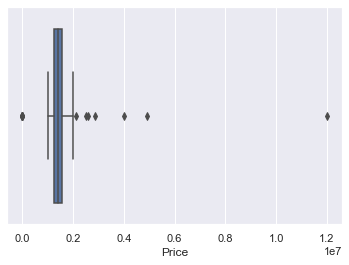

In [48]:
District=Sale_DF[Sale_DF['District']=='الرمال']
sns.boxplot(District['Price'])

C:\Users\skills 11-10-21\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


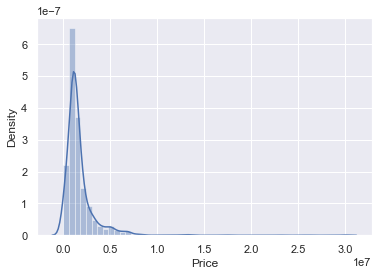

In [49]:
sns.distplot(Sale_DF['Price']);

In [50]:
# OUTLIERS
q2 = Sale_DF.Price.quantile(q=0.4)
q1 = Sale_DF.Price.quantile(q=0.1)
IQR = q2 -  q1
OUTLIER = q2 + 1.5 * IQR
OUTLIER

2213749.9999999995

C:\Users\skills 11-10-21\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Price'>

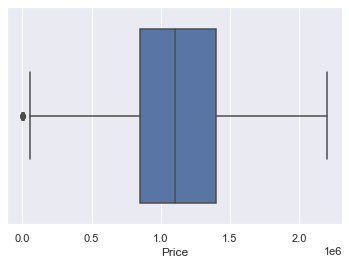

In [51]:
#PLOTTING THE BOX PLOT EXCLUDING THE OUTLIERS
sns.boxplot( Sale_DF[Sale_DF.Price<=OUTLIER].Price)

C:\Users\skills 11-10-21\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


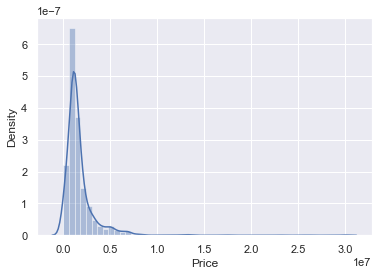

In [52]:
sns.distplot(Sale_DF['Price']);

In [53]:
# top 10
Sale_DF['District'].value_counts().head(10)

طويق              379
الرمال            222
المونسية          127
بدر               101
الملقا             75
منفوحة الجديدة     62
النرجس             61
النظيم             57
ظهرة لبن           57
الدار البيضاء      53
Name: District, dtype: int64

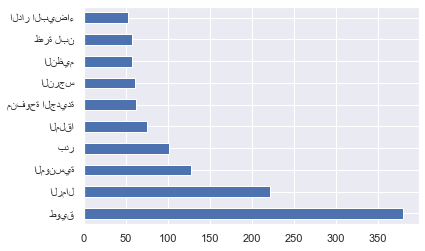

In [54]:
Sale_DF['District'].value_counts()[:10].plot(kind='barh');

In [55]:
Top_District =Sale_DF[['District' ,'Price']].groupby('District').mean().reset_index().sort_values(by = 'Price', ascending = False)
Top_District.head(10)

,District,Price
119,عرقة,1.190000e+07
72,الملقا,6.151333e+06
21,الرائد,6.000000e+06
52,الغدير,5.750000e+06
55,الفلاح,5.720000e+06
82,النخيل,5.400000e+06
108,حطين,5.392174e+06
93,الوادي,5.210000e+06
4,الأمانة,5.000000e+06
92,الواحة,5.000000e+06


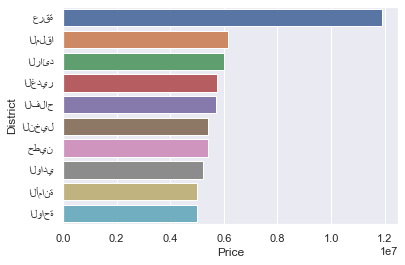

In [56]:
sns.barplot(data=Top_District.head(10), x='Price',y='District', palette = 'deep');

In [57]:
Sale_DF.describe()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
count,2.284000e+03,2284.000000,2284.000000,2284.000000,2284.000000
mean,1.701773e+06,4.609457,4.608144,400.453152,15.228109
std,1.885837e+06,1.033312,1.383890,314.924388,5.261458
min,1.000000e+02,1.000000,1.000000,50.000000,1.000000
25%,9.200000e+05,4.000000,4.000000,270.000000,15.000000
50%,1.200000e+06,5.000000,5.000000,360.000000,15.000000
75%,1.850000e+06,5.000000,5.000000,420.000000,15.000000
max,3.000000e+07,8.000000,7.000000,7000.000000,100.000000


# counting correlation

In [58]:
Sale_DF.corr()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
Price,1.000000,0.177164,0.327576,0.617524,-0.026862
Num_Of_Bedrooms,0.177164,1.000000,0.506473,0.132998,-0.041776
Num_Of_Bathrooms,0.327576,0.506473,1.000000,0.210469,-0.038732
Size(m²),0.617524,0.132998,0.210469,1.000000,-0.047050
StreetWidth,-0.026862,-0.041776,-0.038732,-0.047050,1.000000


In [59]:
Sale_DF.cov()

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),StreetWidth
Price,3.556381e+12,345232.697224,854904.496637,3.667449e+08,-266528.294745
Num_Of_Bedrooms,3.452327e+05,1.067734,0.724251,4.327955e+01,-0.227125
Num_Of_Bathrooms,8.549045e+05,0.724251,1.915150,9.172693e+01,-0.282016
Size(m²),3.667449e+08,43.279550,91.726926,9.917737e+04,-77.960181
StreetWidth,-2.665283e+05,-0.227125,-0.282016,-7.796018e+01,27.682941


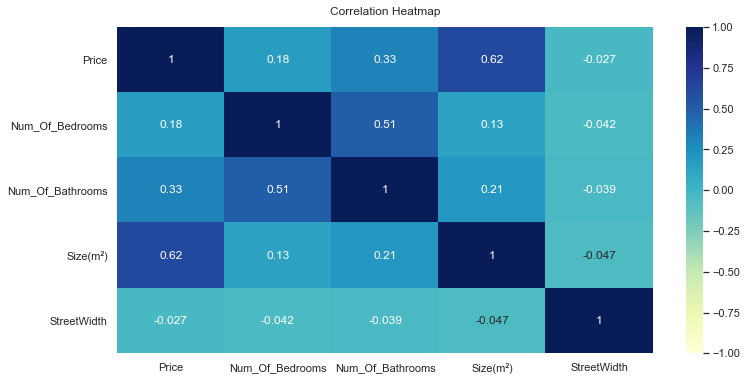

In [60]:
plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(Sale_DF.corr(), vmin=-1, vmax=1, annot=True,cmap="YlGnBu")
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.show()

- The "Size" feature has high positive correlation 0.61 with our target "Price"
- The "Num_Of_Bathrooms" feature has positive correlation 0.34 with our target "Price"
- The "Num_Of_Bedrooms" feature has low positive correlation 0.18 with our target "Price"

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


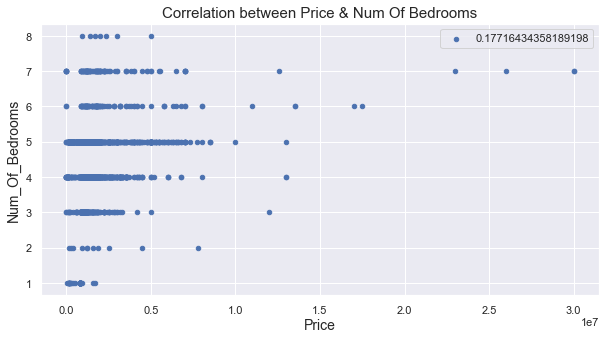

In [61]:
corr = Sale_DF["Price"].corr(Sale_DF['Num_Of_Bedrooms']) 
Sale_DF.plot(kind="scatter",y="Num_Of_Bedrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Num Of Bedrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("Num_Of_Bedrooms" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


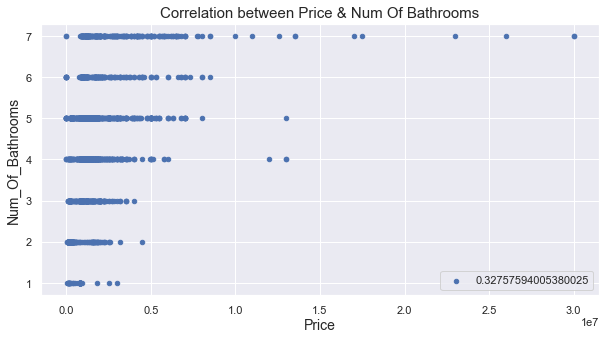

In [62]:
corr = Sale_DF["Price"].corr(Sale_DF['Num_Of_Bathrooms']) 
Sale_DF.plot(kind="scatter",y="Num_Of_Bathrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Num Of Bathrooms" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("Num_Of_Bathrooms" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


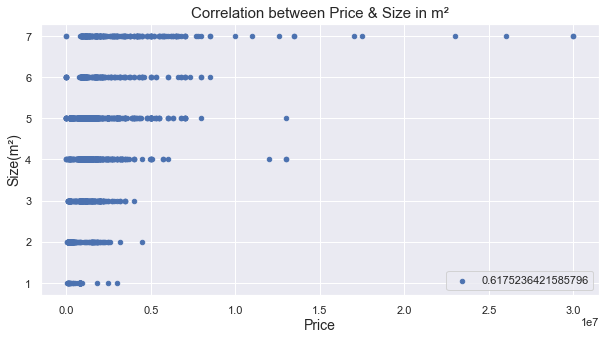

In [63]:
corr = Sale_DF["Price"].corr(Sale_DF['Size(m²)']) 
Sale_DF.plot(kind="scatter",y="Num_Of_Bathrooms" , x="Price",figsize=(10,5) , label = corr)
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Price" , fontsize=14)
plt.ylabel("Size(m²)" , fontsize=14)
plt.legend();

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
No handles with labels found to put in legend.


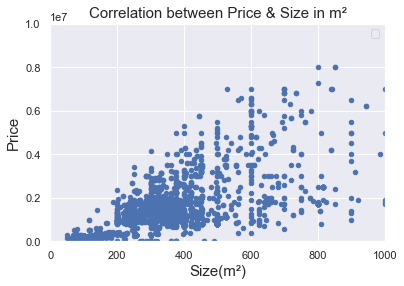

In [64]:
#Zoomed in plot for the price vs size(m2)

Sale_DF.plot(x="Size(m²)", y='Price', kind='scatter')
plt.xlim([0, 1000])
plt.ylim([0,1e7])
plt.title("Correlation between Price & Size in m²" , fontsize=15)
plt.xlabel("Size(m²)" , fontsize=15)
plt.ylabel("Price" , fontsize=15)
plt.legend();

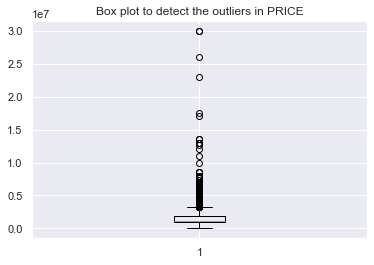

In [65]:
plt.boxplot(Sale_DF["Price"])
plt.title("Box plot to detect the outliers in PRICE")
plt.show()

In [66]:
Sale_DF.Price.describe()

count    2.284000e+03
mean     1.701773e+06
std      1.885837e+06
min      1.000000e+02
25%      9.200000e+05
50%      1.200000e+06
75%      1.850000e+06
max      3.000000e+07
Name: Price, dtype: float64

In [67]:
Sale_DF[Sale_DF.index.duplicated()]

,Price,Num_Of_Bedrooms,Num_Of_Bathrooms,Size(m²),District,StreetWidth
0,1150000.0,5.0,5.0,420.0,طويق,15.0
2,250000.0,5.0,5.0,100.0,الخالدية,10.0
3,800000.0,1.0,1.0,500.0,غبيرة,5.0
6,120000.0,4.0,2.0,109.0,الجرادية,10.0
8,1000000.0,5.0,5.0,390.0,ظهرة لبن,20.0
...,...,...,...,...,...,...
961,1000000.0,5.0,4.0,375.0,الحزم,15.0
962,6200000.0,5.0,7.0,944.0,الأجيال,15.0
963,6300000.0,6.0,5.0,718.0,القيروان,15.0
964,1850000.0,4.0,4.0,385.0,المونسية,15.0


In [68]:
Sale_DF.columns.duplicated().any()

False

In [69]:
Sale_DF= Sale_DF.loc[~Sale_DF.index.duplicated(), :]

In [70]:
Sale_DF.shape

(1186, 6)

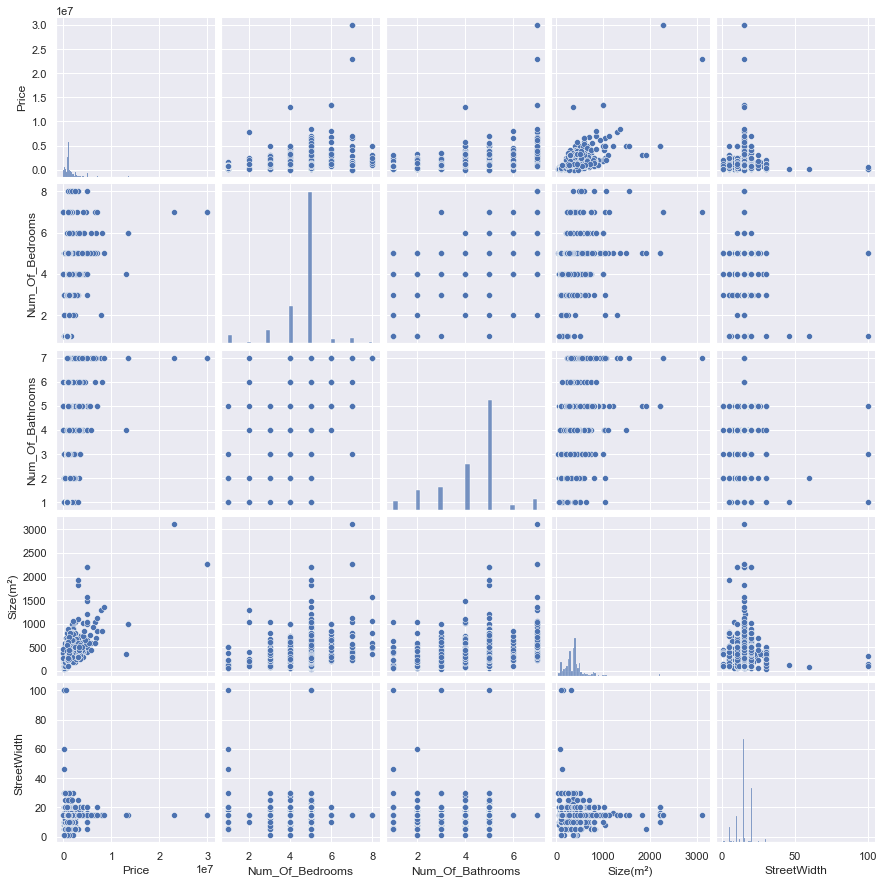

In [71]:
sns.pairplot(Sale_DF);